In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
from jax import random
import seaborn as snb

# distributions
from scipy.stats import norm
from scipy.stats import multivariate_normal as mvn
from scipy.stats import poisson

# for plotting and visualization
from exercise8 import plot_predictions
from exercise8 import eval_density_grid

# style stuff
snb.set_style('darkgrid')
snb.set(font_scale=1.25)

# 02477 Bayesian Machine Learning - Exercise 8

The purpose of this exercise is to become familiar with sampling-based methods. We will briefly touch **ancestral sampling** and **importance sampling**, but spend most of the time diving into **Markov Chain Monte Carlo methods** via the **Metropolis-Hastings algorithm**. After studying the properties of the algorithms, we will apply to a Poisson regression model for fully Bayesian inference.

**Content**

- Part 1: Ancestral sampling
- Part 2: Implementing the Metropolis-Hastings algorithm
- Part 3: The Metropolis-Hastings algorithm for 1D and 2D problems 
- Part 4: Metroplis-Hastings for Bayesian Poisson regression
- Part 5: Importance sampling



**Note**: The exercise contains several **discussion questions**, which are questions, where are supposed to actively experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs. Instead of proving the full description for every discussion question, we simply tag it with: [**Discussion question**] after the question.

For later convenience, we will implement the density of the normal and the so-called half-normal distributions:

In [5]:
# Normal distribution
log_npdf = lambda x, m, v: -0.5*(x-m)**2/(v) - 0.5*jnp.log(2*jnp.pi*v)
npdf = lambda x, m, v: jnp.exp(log_npdf(x, m, v))

# Half-normal distribution
log_half_npdf = lambda x, m, v: jnp.log(2) -0.5*(x-m)**2/(v) - 0.5*jnp.log(2*jnp.pi*v)
half_npdf = lambda x, m, v: jnp.exp(log_half_npdf(x, m, v))

## Part 1:  Ancestral sampling

**Ancestral sampling** is a simple technique for sampling from joint probability distribution using conditional distributions. Consider the following model for $p(x_1, x_2, x_3, x_4)$:

$$\begin{align*}
x_1 &\sim \mathcal{N}(x_1|0, 3)\\
x_2 &\sim \mathcal{N}(x_2|1, 1)\\
x_3|x_2, x_1 &\sim \mathcal{N}(x_3|x_1+x_2, 2)\\
x_4|x_3 &\sim \mathcal{N}(x_4|x_3^2, 1)
\end{align*}$$

with the joint distribution given by
$$\begin{align*}
p(x_1, x_2, x_3, x_4) = p(x_1)p(x_2)p(x_3|x_1, x_2)p(x_4|x_3).
\end{align*}$$

**Task 1.1**: Use ancestral sampling to generate $S = 1000$ samples from the joint distribution $p(x_1, x_2, x_3, x_4)$.

*Hints*:
-  *Start by generating samples from the marginal distributions of $p(x_1)$ and $p(x_2)$, i.e. $x_1^{(i)} \sim p(x_1)$ and $x_2^{(i)} \sim p(x_2)$ for $i = 1, \dots, S$*
-  *Next, then for each pair of samples $x_1^{(i)}, x_2^{(i)}$ generate a sample from $x_3^{(i)} \sim p(x_3|x_1^{(i)}, x_2^{(i)})$ and so on.*
-  *You can use `jax.random.normal(key, shape=(S,))` to generate an array of `S` i.i.d. samples from $\mathcal{N}(0, 1)$*
-  *Recall: The `key`-argument in JaX determines the state for the random number generator, so if you call `jax.random.normal(key, shape=(S,))` several times in your code with the same key, then you'll get the exact same numbers every time. So make you to provide a different `key`.
- *You can split a single key into multiple keys as follows: `key1, key2, key3, key4 = random.split(key, num=4)`.*
-  More information about random number generation in JaX can be found here: https://docs.jax.dev/en/latest/random-numbers.html*



In [6]:
v1 = 3
m1 = 0
m2 = 1
v2 = 1
v3 = 2
v4 = 1

key = random.key(seed = 0)
key1, key2, key3, key4 = random.split(key=key, num=4)
N = 1000

xs1 = random.normal(key = key1, shape = (N,1)) * jnp.sqrt(v1) + m1
xs2 = random.normal(key = key2, shape = (N,1)) * jnp.sqrt(v2) + m2
xs3 = random.normal(key = key3, shape = (N,1)) * jnp.sqrt(v3) + xs2 + xs1
xs4 = random.normal(key = key4, shape = (N,1)) * jnp.sqrt(v4) + xs3**2

**Task 1.2**: Use the samples from the previous task to compute the marginal mean, variance, and a 95\% interval of $p(x_4)$.



Suppose, we had observed some data $\mathbf{y}$ with a dependence on $x_1$ such that

$$\begin{align*}
p(x_1, x_2, x_3, x_4|\mathbf{y}) = p(x_1|\mathbf{y})p(x_2)p(x_3|x_1, x_2)p(x_4|x_3).
\end{align*}$$


If we can generate sample from the posterior of $x_1$ given $\mathbf{y}$, then we can also use ancestral sampling to generate samples from $p(x_4|\mathbf{y})$ and subsequently compute summary statistics. We would follow the same strategy as in the previous two tasks, except we would start by sampling from $p(x_1|\mathbf{y})$ rather than $p(x_1)$. Later in the exercise, we will use **ancestral sampling** this way to make predictions in a Poisson regression model after having obtained posterior samples via MCMC. But before we'll get to that, we will first dive into MCMC and Metropolis-Hastings.

In [7]:
print(f'Mean: {xs4.mean()}')
print(f'Variance: {xs4.var()}')
print(f'95 percent CI: {jnp.quantile(a = xs4, q = jnp.array([0.025, 0.975]))}')

Mean: 6.9823079109191895
Variance: 104.94754791259766
95 percent CI: [-1.0459886 34.661083 ]


## Part 2:  Implementing the Metropolis-Hastings algorithm

Up until know we have used the **Laplace approximation** to **approximate** the posterior distribution of several models. Rather than approximating a target posterior using a specific family of distributions, e.g. Gaussians, sampling-based methods aim to generate samples from the distribution of interest without making any assumptions of the shape of the distribution.  If we can obtain a set of samples from the posterior, we can approximate all quantities of practical interest using the set of samples. For example, if $\mathbf{\theta}^{1}, \mathbf{\theta}^{2}, \dots, \mathbf{\theta}^{S} \sim p(\mathbf{\theta}|\mathbf{y})$ for $\theta \in \mathbb{R}^D$, then we can approximate the posterior expectation of any function $f(\theta)$ using a **Monte Carlo estimator** as follows

$$\begin{align*}
    \mathbb{E}_{\mathbf{\theta}|\mathbf{y}}\left[f(\mathbf{\theta})\right] \approx \frac{1}{S}\sum_{i=1}^S f(\mathbf{\theta}^i).
\end{align*}$$

In practice, it turns out to be very difficult to obtain **i.i.d** samples from general posterior distributions.  However, **Markov Chain Monte Carlo methods (MCMC)** provides a method for generating samples from almost any reasonable distribution, but the price we pay is that the samples are often highly correlated, thus reducing the effective sample size.

The core idea of MCMC methods is to construct a Markov chain such that its **stationary distribution** will be equal to the distribution we want to sample from. Informally, we are creating a type of random walk that explores the parameter space of the target distribution in way where regions with high density are visited more frequently than areas with low density.



**The Metropos-Hastings algorithm**

Today, we will work with the algorithm called the **Metropolis-Hastings**  algorithm, which is a generalization of the **Metropolis** algorithm discussed in the lecture. 

The purpose of the Metropos-Hastings algorithm is to generate samples from a distribution of interest. We will refer to this distribution as the **target** distribution and denote it by $p_t$. This could be any distribution, e.g. a prior distribution such that $p_t(\theta) = p(\theta)$ or a posterior distribution such that $p_t(\theta) = p(\mathbf{\theta}|\mathbf{y})$. A key property of the algorithm is that we only need t obe able to evaluate the target density up to constant, i.e. if $p_t(\mathbf{\theta}) = \frac{1}{Z}\tilde{p}_t(\mathbf{\theta})$ for some unknown $Z > 0$, then it is sufficient to be able to evaluate $\tilde{p}_t(\mathbf{\theta})$.

Every iteration of the MH algorithm proceeds as follows. Assume that the sample at iteration $k-1$ is $\theta^{k-1}$ and we want to compute the sample for iteration $k$. Then, the first step is to generate a new **candidate sample** $\theta^{\star}$ using a **proposal distribution** $q(\theta^{\star}|\theta^{k-1})$, where the proposal distribution is chosen in a way such that it is easy to sample from it. The **Metropolis**-algorithm requires the proposal distribution to be **symmetric**, whereas the **Metropolis-Hastings**-algorithm generalizes this to potential non-symmetric proposal distributions by accounting for the proposal distribution when computing the **acceptance probabilities**.

In this exercise, we will use isotropic Gaussian distributions as proposal distributions:

\begin{align*}
    q(\theta^{\star}|\theta^{k-1}) = \mathcal{N}(\theta^{\star}|\theta^{k-1}, \tau^2 \mathbf{I}) \quad\text{for}\quad \tau > 0,
\end{align*}

or equivalently,

\begin{align*}
    \theta^{\star} = \theta^{k-1} + e_n, \quad\quad e_n \sim \mathcal{N}(0, \tau^2 \mathbf{I}).
\end{align*}


That is, at iteration $k$, we generate the new candidate sample $\mathbf{\theta}^{\star}$ by taking sample for iteration $k-1$, i.e. $\mathbf{\theta}_{k-1}$, and adding a small amount of noise to it. The parameter $\tau^2$ controls the variance of the proposal distribution,  and hence, it controls how much noise we add to $\mathbf{\theta}^k$ when generating the candidate sample $\mathbf{\theta}^{\star}$. In other words, the parameter $\tau$ controls the **step-size** of the algorithm.
 
Once the candidate sample $\mathbf{\theta}^{\star}$ has been generated, the next step is to calculate the **acceptance probability** $A_k$ is given by

\begin{align*}
A_k = \min(1, r_k), \quad\quad\quad\text{where}\quad r_k = \frac{p_t(\mathbf{\theta}^{\star})  q(\mathbf{\theta}^{k-1}|\mathbf{\theta}^{\star}) }{p_t(\mathbf{\theta}^{k-1}) q(\mathbf{\theta}^{\star}|\mathbf{\theta}^{k-1})} \tag{1}.
\end{align*}

We now accept the new candidate sample $\mathbf{\theta}^{\star}$ with probability $A_k \in \left[0, 1\right]$. We can implement this mechanism by generating a sample $u_k \sim \mathcal{U}(0, 1)$ from a uniform distribution in the interval $(0, 1)$. If $u_k < A_k$, we accept the candidate $\mathbf{\theta}^{\star}$ and set $\mathbf{\theta}^{k} = \mathbf{\theta}^{\star}$. Otherwise, we reject new candidate and set $\mathbf{\theta}^{k} = \mathbf{\theta}^{k-1}$. That is

\begin{align*}
\mathbf{\theta}_k = \begin{cases}\mathbf{\theta}^{\star} & \text{if}\quad u_k < A_k\\ \tag{2}
\mathbf{\theta}^{k-1} & \text{otherwise}\end{cases}
\end{align*}

The Metropolis-Hastings algorithm proceeds like this until we have reached a predefined number of iterations. Recall, when working with probabilities on computers, it is numerically more stable to do as many calculations in the log-domain as possible and exponentiate as late as possible (if at all necessary). Therefore, we should calculate $\log(r_k)$ and calculate $A_k$ as

\begin{align*}
A_k = \min(1, \exp[\log(r_k)]) \tag{3}
\end{align*}


You task is now to implement the MH-hastings algorithm below. Since the MH-algorithm is inherently stochastic, it can be difficult to debug. Therefore, we will apply it to distribution, where we already know the mean and variance such that we can verify that the sampler works as intended. 

**Task 2.1**: Complete the implementation of the Metropolis-Hastings algorithm below. See eq. (1), (2) and (3) above. Don't hesitate to ask for help if you are stuck in this question.


In [8]:
def metropolis(log_target, num_params, tau, num_iter, theta_init=None, seed=0):    
    """ Runs a Metropolis-Hastings sampler 
    
        Arguments:
        log_target:         function for evaluating the log target distribution, i.e. log \tilde{p}(theta). The function expect a parameter of size num_params.
        num_params:         number of parameters of the joint distribution (integer)
        tau:                standard deviation of the Gaussian proposal distribution (positive real)
        num_iter:           number of iterations (integer)
        theta_init:         vector of initial parameters (np.array with shape (num_params) or None)        
        seed:               seed (integer)

        returns
        thetas              np.array with MCMC samples (np.array with shape (num_iter+1, num_params))
    """ 
    
    # set initial key
    key = random.PRNGKey(seed)

    if theta_init is None:
        theta_init = jnp.zeros((num_params))
    
    # prepare lists 
    thetas = [theta_init]
    accepts = []
    log_p_theta = log_target(theta_init)

    burn_in = num_iter // 10
    burn_in = 0
    key, key_proposal, key_accept = random.split(key, num=3)
    Us = random.uniform(key = key_accept, shape = (num_iter + burn_in, ))
    ens = random.normal(key = key_proposal, shape = (num_iter + burn_in, num_params)) * tau
    
    for k in range(num_iter + burn_in):

        # update keys: key_proposal for sampling proposal distribution and key_accept for deciding whether to accept or reject.
        
        ##############################################
        # Your solution goes here
        ##############################################
        
        theta_star = thetas[k] + ens[k,:]
        
        log_p_q_star = log_npdf(x = theta_star, m = thetas[k], v = tau**2 * jnp.identity(num_params))
        
        log_p_target_star = log_target(theta_star)

        log_q_theta = log_npdf(x = thetas[k], m = theta_star, v = tau**2 * jnp.identity(num_params))

        log_p_theta = log_target(thetas[k]) #log_p_target_star
        
        log_rk = log_p_target_star + log_q_theta - log_p_theta - log_p_q_star

        A_k = jnp.min(jnp.array([1, jnp.exp(log_rk[0,0])]))

        if Us[k] < A_k:
            theta_next = theta_star
            accepts.append(True)
        else:
            theta_next = thetas[k]
            accepts.append(False)
    
        ##############################################
        # End of solution
        ##############################################
            
        thetas.append(theta_next)


        
    print('Acceptance ratio: %3.2f' % jnp.mean(jnp.array(accepts)))
        
    # return as np.array
    # thetas = thetas[burn_in:]
    thetas = jnp.stack(thetas)

    # check dimensions and return
    assert thetas.shape == (num_iter+1, num_params), f'The shape of thetas was expected to be ({num_iter+1}, {num_params}), but the actual shape was {thetas.shape}. Please check your code.'
    return thetas


# sanity check: estimate the mean and variance of a N(x|1,3) Gaussian distribution
p_target = lambda x: log_npdf(x, 1., 3.)

# run sampler
thetas = metropolis(p_target, 1, 2., 20000, theta_init=jnp.array([0]))

# estimate the mean and variance of p_target and relative errors
mean_thetas, var_thetas = jnp.mean(thetas), jnp.var(thetas)
rel_err_mean, rel_err_var = (mean_thetas - 1.)/1., (var_thetas - 3.)/3.

print('\nSanity check: Running the sampling with N(x|1, 3) as target')
print(f'Estimated mean:\t\t{mean_thetas:3.2f} (rel. err: {rel_err_mean:3.2f})')
print(f'Estimated variance:\t{var_thetas:3.2f} (rel. err: {rel_err_var:3.2f})\n')

if np.abs(rel_err_mean) < 0.05 and np.abs(rel_err_var) < 0.05:
    print('The relative errors for the first two central moments are less than 5%. Everything looks ok.')
else:
    print('The relative errors for the first two central moments are larger than 5%. If this happens consistently, something is likely wrong. Check your implementation')

Acceptance ratio: 0.67

Sanity check: Running the sampling with N(x|1, 3) as target
Estimated mean:		1.05 (rel. err: 0.05)
Estimated variance:	2.92 (rel. err: -0.03)

The relative errors for the first two central moments are less than 5%. Everything looks ok.


**Task 2.2**: Why is it not necessary to include the proposal probabilities $q(\theta^{k-1}|\theta^{\star})$ and $q(\theta^{\star}|\theta^{k-1})$ when computing the acceptance probability for Gaussian proposals?







**Task 2.3**: What is the resulting acceptance probability $A_k$ when the candidate sample $\theta^{\star}$ has higher density value than the previous sample $\theta^{k-1}$?





**Task 2.4**: Use eq. (1) one above to argue that we don't need to be able to evaluate the target distribution, but only the target density of up to a constant. That is, we only need to be evaluate $\tilde{p}_t$. Why is this important in Bayesian modelling?



## Part 3:  The Metropolis-Hastings algorithm for 1D and 2D problems 

The code below runs the Metropolis-Hastings algorithm for the target distribution specified through the **log_target** function. 

Acceptance ratio: 0.84


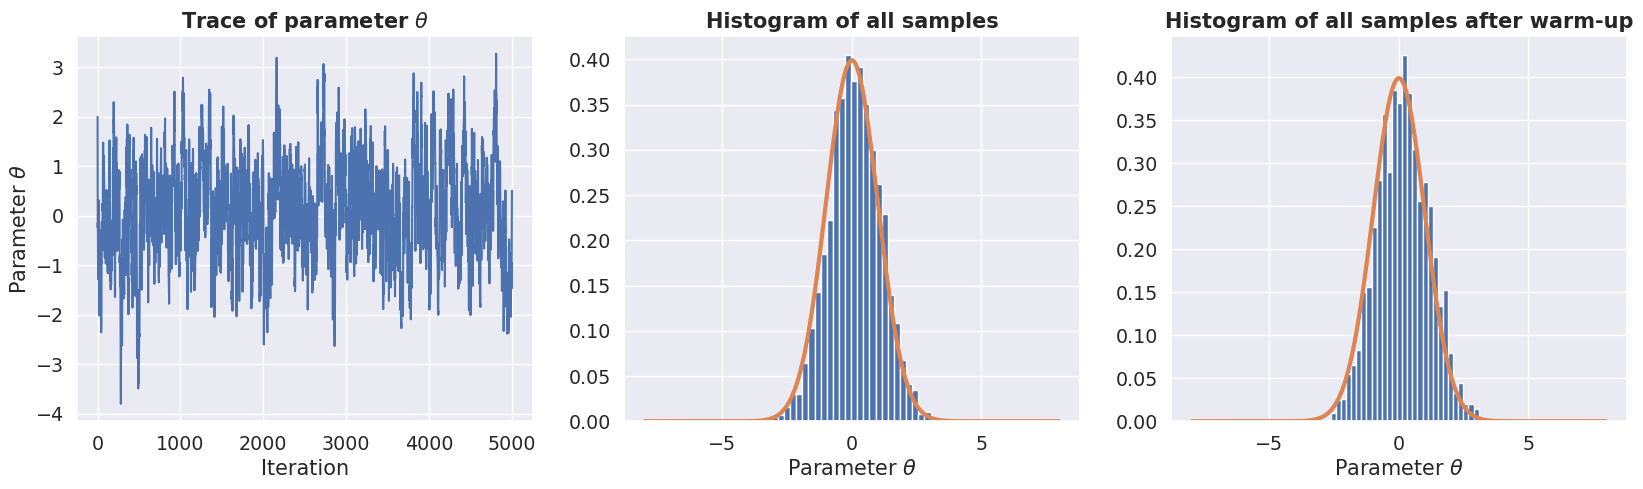

In [14]:
# specify number of parameters in the target distribution
num_params = 1

# specify the target distribution
log_target = lambda x: log_npdf(x, 0, 1)

# specify the parameters of the MH algorithm
num_iterations = 5000
warm_up = int(0.5*num_iterations)
tau = 0.5

# run sampler
thetas = metropolis(log_target, num_params, tau, num_iterations, theta_init=jnp.array([(-10)]), seed=0).squeeze()

# plot resutls
xs = np.linspace(-8, 8, 1000)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].plot(thetas)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Parameter $\\theta$')
axes[0].set_title('Trace of parameter $\\theta$', fontweight='bold')

axes[1].hist(thetas, 30, density=True);
axes[1].plot(xs, np.exp(log_target(xs)), linewidth=3)
axes[1].set_xlabel('Parameter $\\theta$')
axes[1].set_title('Histogram of all samples', fontweight='bold')

axes[2].hist(thetas[warm_up:], 30, density=True);
axes[2].plot(xs, np.exp(log_target(xs)), linewidth=3)
axes[2].set_xlabel('Parameter $\\theta$');
axes[2].set_title('Histogram of all samples after warm-up', fontweight='bold');

**Task 3.1**: Play around with the initial value of the chain. Why do we need to discard the first proportion of samples (the warm-up phase)? [**Discussion question**]

It needs time to find the distribution
 


**Task 3.2**: Go back to the implementation of the `metropolis` function and make the function print the acceptance rate, i.e. the number of accepted samples divided by the total number of iterations.


**Task 3.3**: What happens to the acceptance ratio if you change the variance of the proposal distribution, e.g. $\tau = 0.1$, $\tau = 10$ or $\tau=500$? How well does the resulting histogram of the samples match the true target distribution? [**Discussion question**]

**Task 3.4**: Using $\tau = 0.5$ and keeping warm up at 50%, how many iterations do you need before distribution of the samples resembles the target distribution (based on a visual comparison of the target density and the histogram of the samples)? [**Discussion question**]


**Task 3.5**: Use the MH-algorithm to estimate the mean, the variance and the probability that $\theta > 1$ for the following two distributions given below. 

*Hints*
- *Plot the trace to verify that the chains appear to have converged. If not adapt the proposal variance and/or the number of samples*
- *Plot the target densities as well as the histogram of the resulting samples to verify that everything looks ok*


$$\begin{align*}
p(\theta) &\propto \exp(-|\theta-3|)\\
p(\theta) &= \frac{3}{40}\exp(-\frac12 |\theta-3|) + \frac{7}{20} \exp(-|\theta+2|)  \\
p(\theta) &= 2\phi(\theta)\Phi(5\theta),
\end{align*}$$


where $\phi(\cdot)$ and $\Phi(\cdot)$ is the PDF and CDF a standarized normal distribution, respectively. The first distributions in an instance of the family of [Laplace distributions](https://en.wikipedia.org/wiki/Laplace_distribution), the second is a mixture of Laplace distributions and the last distribution is an instance of the family of [skew-normal distributions](https://en.wikipedia.org/wiki/Skew_normal_distribution).



Acceptance ratio: 0.82
mean: 2.2761952877044678
Variance: 9.437057495117188
p(theta > 1): 0.8620689511299133


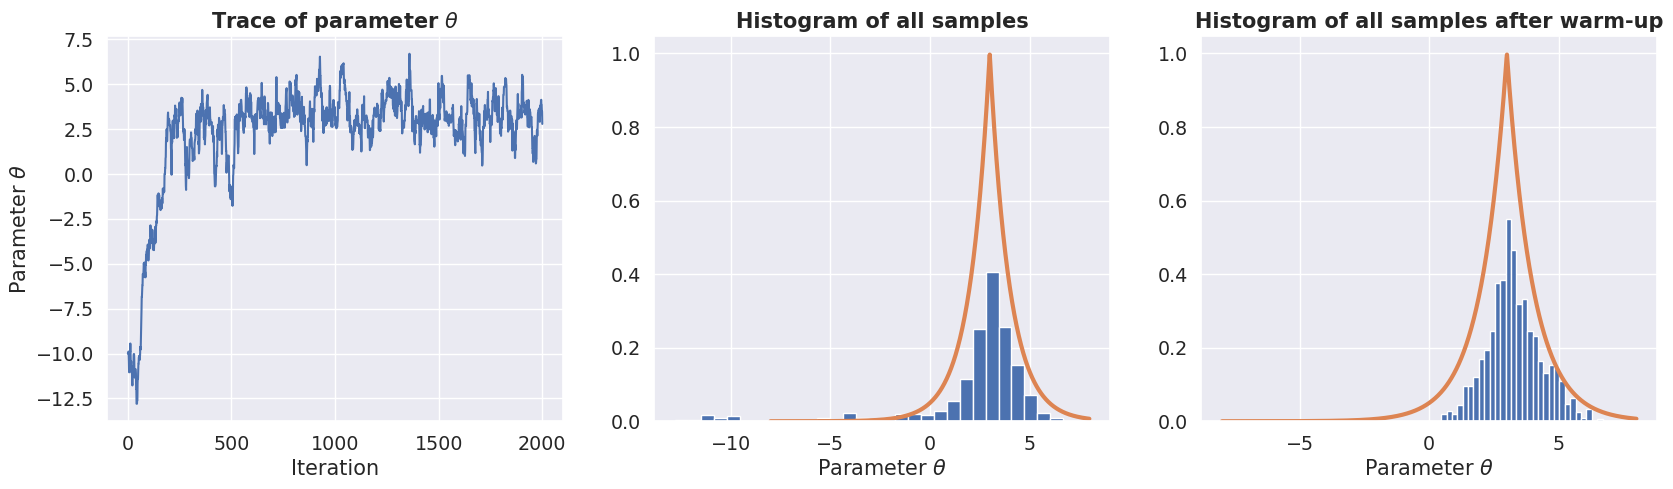

In [19]:
# specify number of parameters in the target distribution
num_params = 1

# specify the target distribution
log_target = lambda x: -jnp.abs(x - 3)

# specify the parameters of the MH algorithm
num_iterations = 2000
warm_up = int(0.5*num_iterations)
tau = 0.5

# run sampler
thetas = metropolis(log_target, num_params, tau, num_iterations, theta_init=jnp.array([(-10)]), seed=0).squeeze()

print(f'mean: {thetas.mean()}')
print(f'Variance: {thetas.var()}')
print(f'p(theta > 1): {jnp.sum(thetas > 1) / len(thetas)}')

# plot resutls
xs = np.linspace(-8, 8, 1000)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].plot(thetas)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Parameter $\\theta$')
axes[0].set_title('Trace of parameter $\\theta$', fontweight='bold')

axes[1].hist(thetas, 30, density=True);
axes[1].plot(xs, np.exp(log_target(xs)), linewidth=3)
axes[1].set_xlabel('Parameter $\\theta$')
axes[1].set_title('Histogram of all samples', fontweight='bold')

axes[2].hist(thetas[warm_up:], 30, density=True);
axes[2].plot(xs, np.exp(log_target(xs)), linewidth=3)
axes[2].set_xlabel('Parameter $\\theta$');
axes[2].set_title('Histogram of all samples after warm-up', fontweight='bold');

Acceptance ratio: 0.87
mean: -0.2431020885705948
Variance: 20.884702682495117
p(theta > 1): 0.36231884360313416


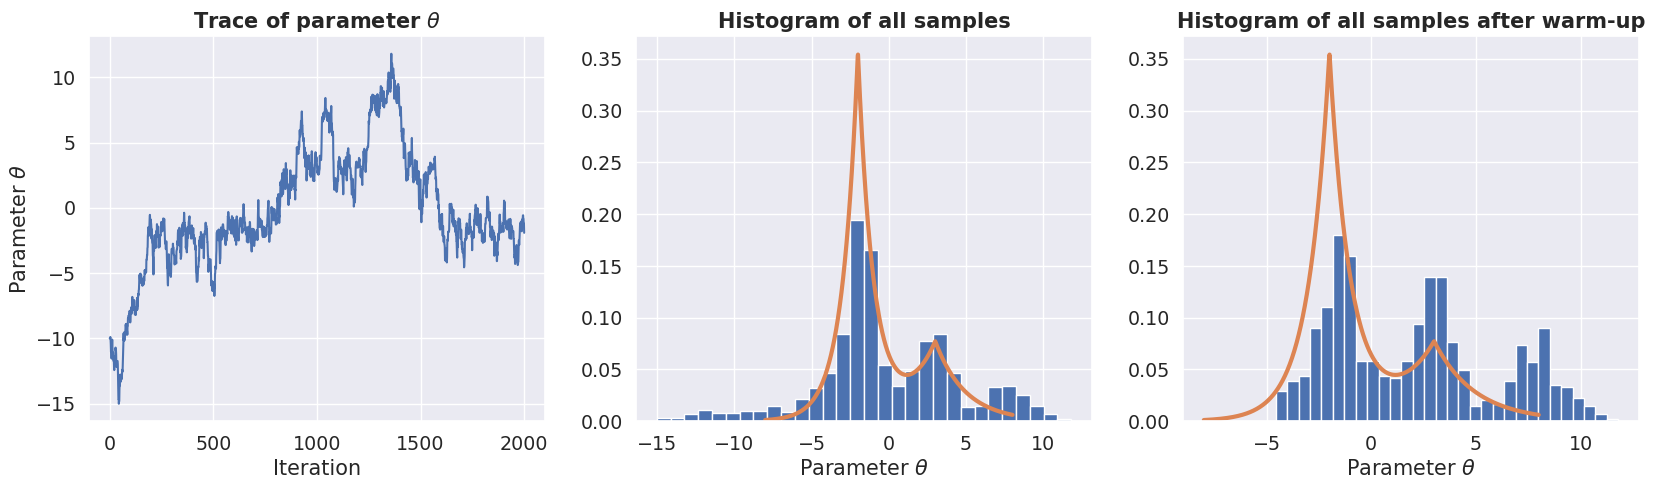

In [20]:
# specify number of parameters in the target distribution
num_params = 1

# specify the target distribution
log_target = lambda x: jnp.log(3/40 * jnp.exp(-1/2 * jnp.abs(x - 3)) +7/20 * jnp.exp((-jnp.abs(x + 2))))


# specify the parameters of the MH algorithm
num_iterations = 2000
warm_up = int(0.5*num_iterations)
tau = 0.5

# run sampler
thetas = metropolis(log_target, num_params, tau, num_iterations, theta_init=jnp.array([(-10)]), seed=0).squeeze()

print(f'mean: {thetas.mean()}')
print(f'Variance: {thetas.var()}')
print(f'p(theta > 1): {jnp.sum(thetas > 1) / len(thetas)}')

# plot resutls
xs = np.linspace(-8, 8, 1000)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].plot(thetas)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Parameter $\\theta$')
axes[0].set_title('Trace of parameter $\\theta$', fontweight='bold')

axes[1].hist(thetas, 30, density=True);
axes[1].plot(xs, np.exp(log_target(xs)), linewidth=3)
axes[1].set_xlabel('Parameter $\\theta$')
axes[1].set_title('Histogram of all samples', fontweight='bold')

axes[2].hist(thetas[warm_up:], 30, density=True);
axes[2].plot(xs, np.exp(log_target(xs)), linewidth=3)
axes[2].set_xlabel('Parameter $\\theta$');
axes[2].set_title('Histogram of all samples after warm-up', fontweight='bold');

Acceptance ratio: 0.73
mean: 0.5823186635971069
Variance: 2.0121512413024902
p(theta > 1): 0.3063468337059021


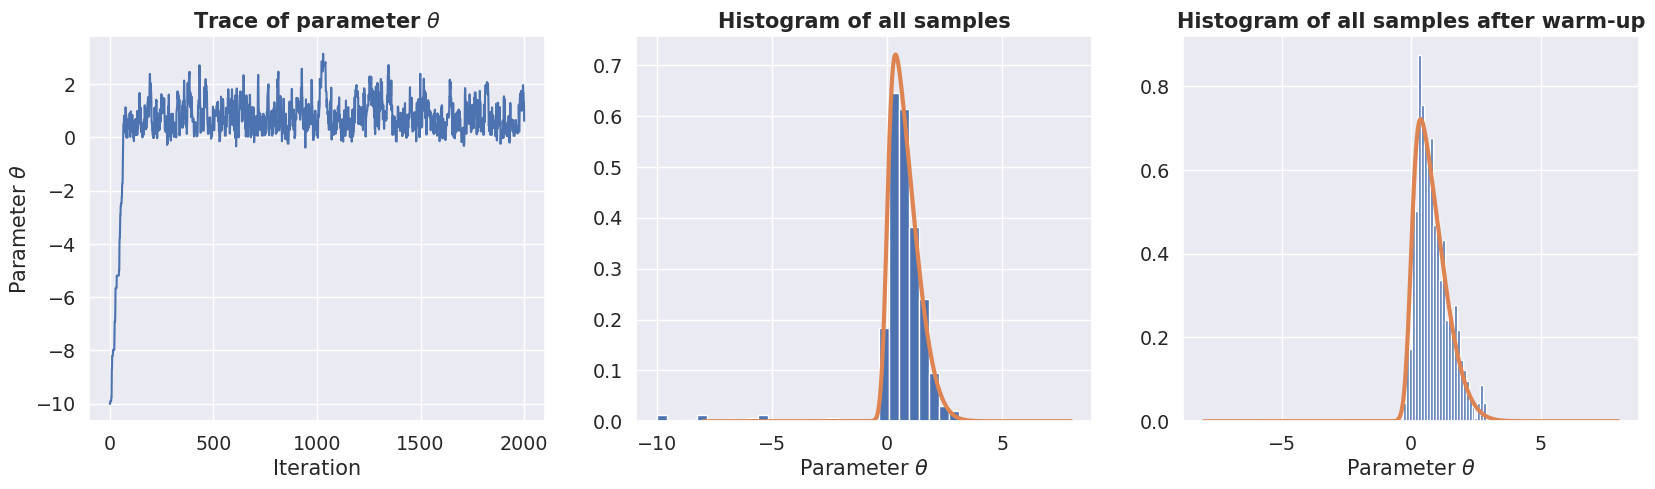

In [22]:
from scipy.stats import norm
# specify number of parameters in the target distribution
num_params = 1

# specify the target distribution
log_target = lambda x: jnp.log(2) + log_npdf(x, m = 0, v = 1) + norm.logcdf(5 * x)


# specify the parameters of the MH algorithm
num_iterations = 2000
warm_up = int(0.5*num_iterations)
tau = 0.5

# run sampler
thetas = metropolis(log_target, num_params, tau, num_iterations, theta_init=jnp.array([(-10)]), seed=0).squeeze()

print(f'mean: {thetas.mean()}')
print(f'Variance: {thetas.var()}')
print(f'p(theta > 1): {jnp.sum(thetas > 1) / len(thetas)}')

# plot resutls
xs = np.linspace(-8, 8, 1000)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].plot(thetas)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Parameter $\\theta$')
axes[0].set_title('Trace of parameter $\\theta$', fontweight='bold')

axes[1].hist(thetas, 30, density=True);
axes[1].plot(xs, np.exp(log_target(xs)), linewidth=3)
axes[1].set_xlabel('Parameter $\\theta$')
axes[1].set_title('Histogram of all samples', fontweight='bold')

axes[2].hist(thetas[warm_up:], 30, density=True);
axes[2].plot(xs, np.exp(log_target(xs)), linewidth=3)
axes[2].set_xlabel('Parameter $\\theta$');
axes[2].set_title('Histogram of all samples after warm-up', fontweight='bold');

#### The Metropolis-Hastings algorithm for 2D problems

Next, we will apply MH algorithm to generate samples from a bivariate normal distribution with correlation $\rho$. That is, the target density is

\begin{align*}
p(\mathbf{\theta}) = \mathcal{N}(\mathbf{\theta}|\mu, \Sigma),
\end{align*}

where $\mathbf{\theta} \in \mathbb{R}^2$, $\mathbf{\mu} = \begin{bmatrix}-4\\ 4\end{bmatrix}$, and $\mathbf{\Sigma} = \begin{bmatrix}1 & \rho \\ \rho & 1\end{bmatrix}$.

There are, of course, much more efficient ways to generate samples from multivarate normal distributions, but here we use the multivariate normal distribution to understand the properties of the MH algorithm.

Acceptance ratio: 0.22
Mean and variance of samples for theta1: -3.93, 2.40
Mean and variance of samples for theta2: 3.96, 2.72
Relative errors theta 1 0.017354965209960938
Relative errors theta 2 -0.009311437606811523


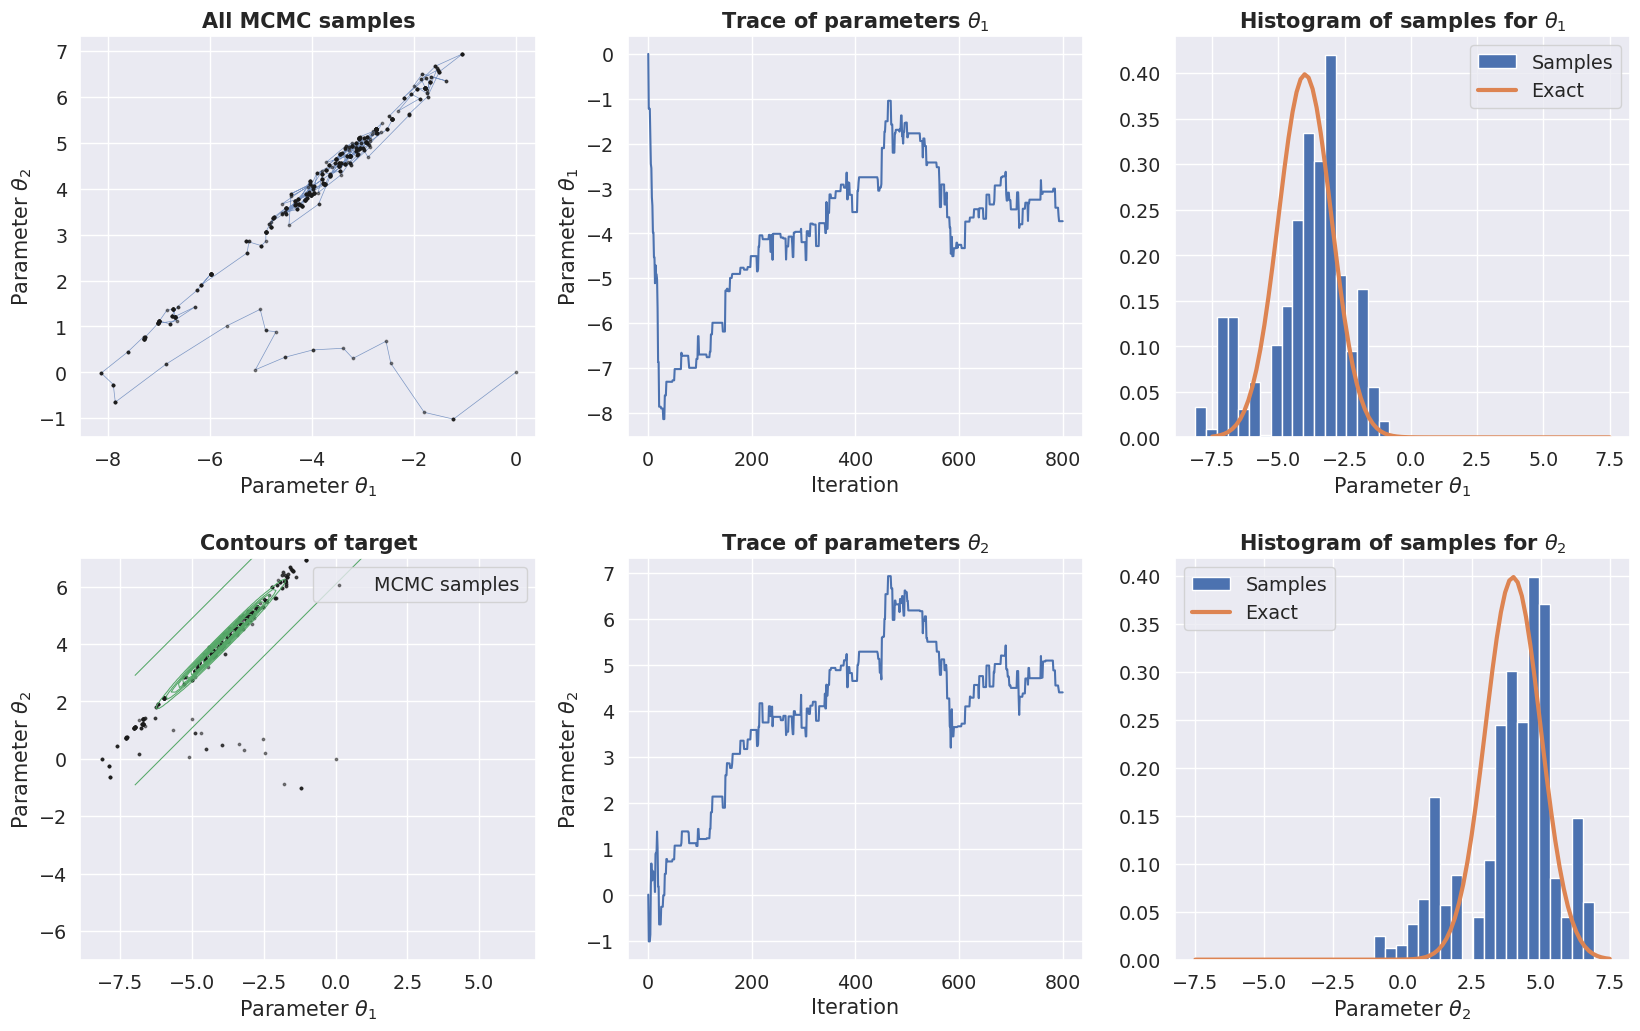

In [27]:
# specify target density
mu = jnp.array([-4, 4])                            # mean 
rho = 0.99                                         # correlation coef.
S = jnp.array([[1, rho], [rho, 1]])                # covariance matrix
log_joint = lambda x: mvn.logpdf(x, mu, S)        # target density

# sampler settings
num_params = 2
num_iterations = 800
warm_up = int(0.5*num_iterations)
tau = 0.5

# run sampler
thetas = metropolis(log_joint, num_params, tau, num_iterations, seed=0)

# discard samples from warm-up phase
#thetas = thetas[warm_up:, :]

# plot
xs = jnp.linspace(-7.5, 7.5, 100)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes[0, 0].plot(*thetas.T, lw=0.5, alpha=0.7, zorder=1)
axes[0, 0].scatter(*thetas.T, c="k", s=3, alpha=0.5, zorder=2)
axes[0, 0].set_xlabel('Parameter $\\theta_1$')
axes[0, 0].set_ylabel('Parameter $\\theta_2$')
axes[0, 0].set_title('All MCMC samples', fontweight='bold')


x_grid, log_density_grid = eval_density_grid(log_joint)
axes[1, 0].scatter(*thetas.T, c="k", s=3, alpha=0.5, label='MCMC samples')
axes[1, 0].contour(x_grid, x_grid, jnp.exp(log_density_grid), levels=15, linewidths=0.75, colors='g')
axes[1, 0].set_xlabel('Parameter $\\theta_1$')
axes[1, 0].set_ylabel('Parameter $\\theta_2$')
axes[1, 0].set_title('Contours of target', fontweight='bold')
axes[1, 0].legend()

for i in range(2):
    axes[i, 1].plot(thetas[:, i])
    axes[i, 1].set_title('Trace of parameters $\\theta_{%d}$' % (i+1), fontweight='bold')
    axes[i, 1].set_xlabel('Iteration')
    axes[i, 1].set_ylabel('Parameter $\\theta_{%d}$' % (i+1))
    
    axes[i, 2].hist(thetas[:, i], 20, density=True, label='Samples')
    axes[i, 2].set_xlabel('Parameter $\\theta_{%d}$' % (i+1))
    axes[i, 2].plot(xs, npdf(xs, mu[i], S[i,i]), linewidth=3, label='Exact')
    axes[i, 2].set_title('Histogram of samples for $\\theta_{%d}$' % (i+1), fontweight='bold')
    axes[i, 2].legend()
    
    print('Mean and variance of samples for theta%d: %3.2f, %3.2f' % (i+1, jnp.mean(thetas[:, i]), jnp.var(thetas[:, i])) )

print(f'Relative errors theta 1 {(jnp.mean(thetas[:,0]) + 4) / 4}')
print(f'Relative errors theta 2 {(jnp.mean(thetas[:,1]) - 4) / 4}')
    
fig.subplots_adjust(hspace=0.3)


**Task 3.6**: Experiment with the number of iterations. How many iterations do you need before the sample mean and variance are equal to the true values (up to, say, 5%-10% relative error)? [**Discussion question**]

**Task 3.7**: What happens to the acceptance ratio if you increase the correlation in the target density to, say, $\rho = 0.7$, $\rho=0.9$, $\rho=0.95$ or $\rho=0.99$? What happens to the accuracy of the moments? [**Discussion question**]


## Part 4:  Metroplis-Hastings for Bayesian Poisson regression

Now we will apply the Metropolis-Hastings algorithm to Bayesian Poisson regression (discussed in week 7). As a case study, we will use a small data set from a study on mortality (Broffiti, 1988), where the authors looked at the mortality rates as a function of age. 

Let's look at the data.

/home/lucas/envs/gpaw-env/envs/bayes/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:121: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


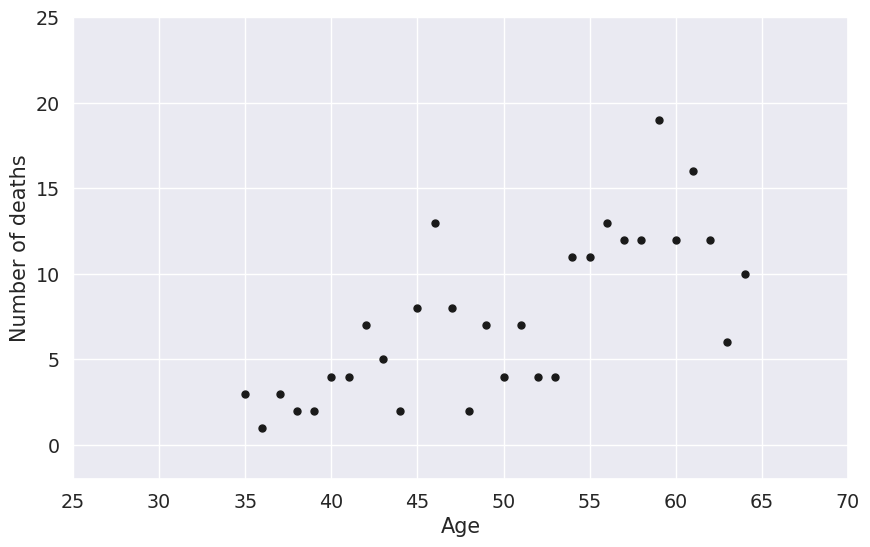

In [28]:
###################################################
# Raw data
###################################################

# The input covariate is age
age = jnp.arange(35, 65).astype(jnp.float64)

# The output is the number of deaths in the study popular for each age
deaths = jnp.array([3, 1, 3, 2, 2, 4, 4, 7, 5, 2, 8, 13, 8, 2, 7, 4, 7, 4, 4, 11, 11, 13, 12, 12, 19, 12, 16, 12, 6, 10])

# number of data points
N = len(deaths)

# Let's standardize the input covariate
m_age = jnp.mean(age)
s_age = jnp.std(age)
standardize = lambda x: (x-m_age)/s_age

# prep data
x = standardize(age)
x = x[:, None]

# Define input points for prediction
age_star = jnp.linspace(25, 70, 100)
x_star = standardize(age_star)

# Let's set-up the design matrix for the training data and the inputs for predictions
design_matrix = lambda x: jnp.column_stack((jnp.ones(len(x)), x))
X_train = design_matrix(x)
X_star = design_matrix(x_star)

# Plotting
def plot_data(ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
    ax.plot(age, deaths, 'k.', markersize=10)
    ax.set_xlabel('Age')
    ax.set_ylabel('Number of deaths')
    
    ax.set_xlim((25, 70))
    ax.set_ylim((-2, 25))


plot_data()

**Linear models for count data**

We will a use **generalized linear model** to model this dataset. Since the target variable $y_n$ is **count data**, i.e., $y_n \in \left\lbrace 0, 1, 2, \dots \right\rbrace$, we will use a Poisson likelihood to model the data. If you don't recall what the Poisson distribution looks like, then the Wikipedia page is useful: https://en.wikipedia.org/wiki/Poisson_distribution. 

The likelihood of a single data point is given by

\begin{align*}
y_n|\mu_n \sim \text{Poisson}(\mu_n),
\end{align*}

where $\mu_n > 0$ is the mean parameter for the Poisson distribution for the $n$'th observation, i.e., $\mathbb{E}_{y_n|\mu_n}\left[y_n\right] = \mu_n$.

Since count data are non-negative, we will use the **log link function** 

\begin{align*}
\log(\mu_n) = f_n \quad\quad \iff \quad \quad \mu_n = \exp(f_n),
\end{align*}

where $f_n = f(\mathbf{x}_n)$ is a linear model with parameters $\mathbf{w} \in \mathbb{R}^2$ evaluated at $\mathbf{x}_n$:

\begin{align*}
f(\mathbf{x}) = \mathbf{w}^T \mathbf{x}_n = w_0 + w_1\cdot\text{age}.
\end{align*}

The model has two parameters: an intercept $w_0$ and a slope $w_1$. To perform Bayesian inference, we will impose a zero-mean Gaussian prior distribution on both:

\begin{align*}
p(\mathbf{w}|\kappa^2) = \mathcal{N}(\mathbf{w}|\mathbf{0}, \kappa^2 \mathbf{I}),
\end{align*}

where $\kappa^2 > 0$ is the variance of the prior. 


**Hyperpriors**

Earlier in the course, we estimated **hyperparameters** like $\kappa$ by optimizing the marginal likelihood. However, since we are dealing with a rather small dataset, we will use **fully Bayesian** and impose a **hyperprior** distribution on $\kappa$. That is, we consider $\kappa$ a random variable and impose a prior distribution on it. Specifically, we will use a **half-normal distribution** as prior for $\kappa$:
\begin{align*}
\kappa \sim \mathcal{N}_+(0, 1)
\end{align*}

The half-normal distribution is just the "positive-part" of a standard normal distribution (https://en.wikipedia.org/wiki/Half-normal_distribution) and it serves to prevent to prior variance of $\mathbf{w}$ from becoming too large such that we risk overfitting.

**The full probabilistic model**

To summarize, the full probabilistic model looks as follows:

\begin{align*}
y_n|\mu_n &\sim \text{Poisson}(\mu_n),\\
\mu_n &= \exp(f_n)\\
f_n &= \mathbf{w}^T \mathbf{x}_n\\
\mathbf{w}|\kappa &= \mathcal{N}(0, \kappa^2\mathbf{I})\\
\kappa &\sim \mathcal{N}_+(0, 1)
\end{align*}


The joint distribution of the model is given by
\begin{align*}
p(\mathbf{y}, \mathbf{w}, \kappa) = \prod_{n=1}^N p(y_n|\mathbf{w})p(\mathbf{w}|\kappa)p(\kappa),
\end{align*}

where we have used $y_n|\mathbf{w} \sim \text{Poisson}(\exp(\mathbf{w}^T \mathbf{x}_n))$. 


One way to understand this model is to consider the "generative story" (via ancestral sampling):
1. Nature samples a value for $\kappa \sim \mathcal{N}_+(0, 1)$.
2. Using that specific value of $\kappa$, nature picks a set of weights $\mathbf{w}|\kappa^2 = \mathcal{N}(0, \kappa^2\mathbf{I})$.
3. Using those specific weights, nature computes the mean value $\mu_n$ for all observations at $\mathbf{x}_n$, i.e. $\mu_n = \exp(\mathbf{w}^T \mathbf{x}_n)$.
4. Finally, nature picks a value for each observation $y_n$ by sampling from $y_n|\mu_n \sim \text{Poisson}(\mu_n)$.


**Posterior inference and making predictions**

Our strategy will be as follows. We will implement a function for evaluating the log joint distribution, and then we will use MCMC (via the Metropolis-Hastings algorithm) to generate samples from the posterior $p(\mathbf{w}, \kappa|\mathbf{y})$. Next, we will use ancestral sampling to generate samples of

-  $f^* = f(\mathbf{x}^*) = \mathbf{w}^T \mathbf{x}^*$,
-  $\mu^* = \exp(f^*)$,
-  $y^*|\mu^* \sim \text{Poisson}(\mu^*)$

for each $\mathbf{x}^*$. Finally, we can compute the desired summary statistics of $y^*$ based on the generated samples.


To be able to use our implementation of the Metropolis-Hastings algorithm, we will define $\theta \in \mathbb{R}^3$ to be a three-dimensional vector containing all 3 parameters to be estimated, i.e. $\theta  = \left[w_0, w_1, \kappa \right]$. 


**Task 4.1**: Implement a function for evaluating the log joint distribution of the Poisson regression model as a function of $\theta$. 

*Hint:*
- *You can use `scipy.stats.poisson.logpmf` to implement the likelihood*
- *Recall $\kappa > 0$ is a stricly positive parameter and hence $p(\kappa) = 0$ for $\kappa < 0$*



In [60]:
from scipy.stats import poisson, multivariate_normal

def log_joint_41(parms):
    W = jnp.array([parms[0], parms[1]])
    kappa = parms[2]

    if kappa <= 0:
        p_kappa = -np.inf
        return p_kappa
    else:
        p_kappa = log_half_npdf(x = kappa, m = 0, v = 1)

    fs = (X_train @ W[:,None]).squeeze()
    mus = jnp.exp(fs)

    p_w = multivariate_normal.logpdf(W, jnp.zeros_like(W), kappa**2 * jnp.identity(len(W)))
    p_y = jnp.sum(poisson.logpmf(deaths, mus))
    return p_kappa + p_w + p_y

**Task 4.2**: Use the Metropolis-Hastings algorithm to generate samples from the posterior $p(\theta|\mathbf{y})$. Make trace plots of all parameters and ensure that the chain appear to have converged.




In [120]:
num_params = 3
num_iterations = 5000
warm_up = int(0.5*num_iterations)
tau = 0.15

# run sampler
thetas = metropolis(log_joint_41, num_params, tau, num_iterations, seed=0)

Acceptance ratio: 0.25


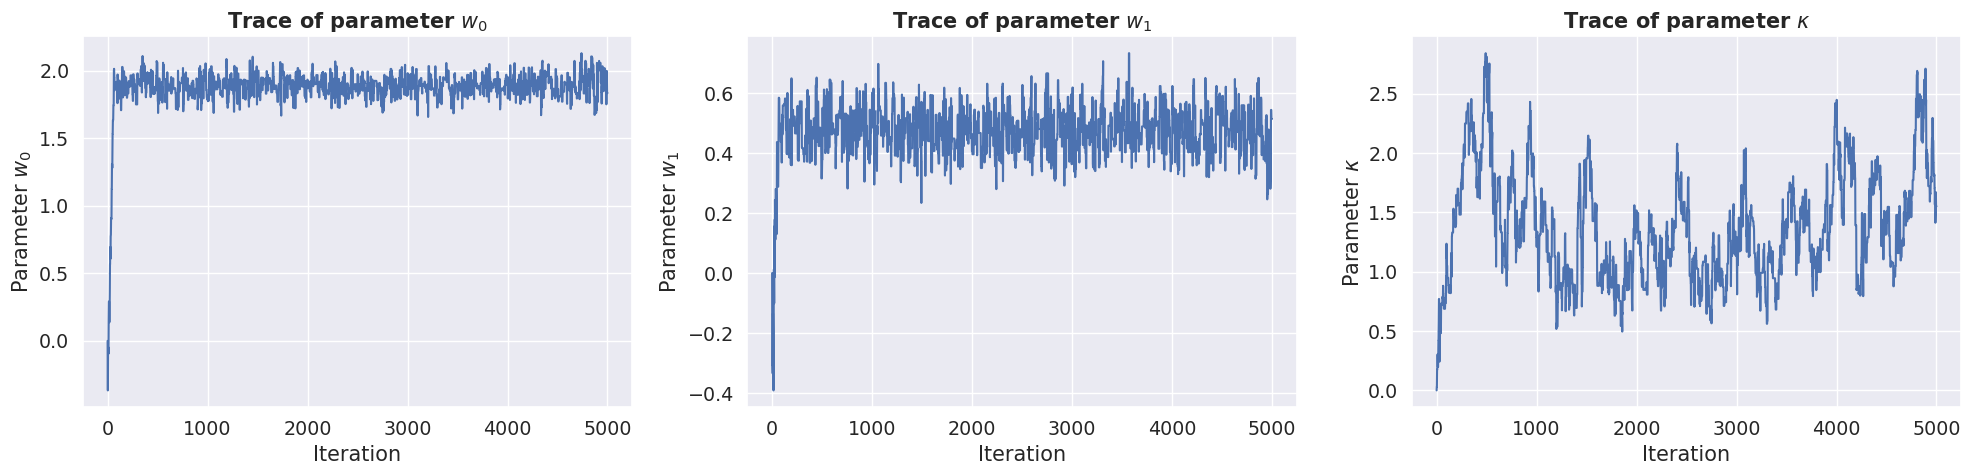

In [121]:
fig, axes = plt.subplots(1, num_params, figsize=(20, 5))

for i in range(num_params):
    axes[i].plot(thetas[:, i])
    axes[i].set_xlabel('Iteration')
    if i < 2:
        axes[i].set_ylabel(f'Parameter $w_{i}$')
        axes[i].set_title(f'Trace of parameter $w_{i}$', fontweight='bold')
    else:
        axes[i].set_ylabel(f'Parameter $\\kappa$')
        axes[i].set_title(f'Trace of parameter $\\kappa$', fontweight='bold')

plt.tight_layout()
plt.show()

**Task 4.3**: Plot a histogram of the posterior samples of $\kappa$ and compare with a histogram of prior samples of $\kappa$. Generate a scatter plot of the posterior samples of the weights and compare to a scatter plot of prior samples of the weights. Based on these plots: do you think the data is more informative about the weights of the linear model $\mathbf{w}$ or the hyperparameter $\kappa$?



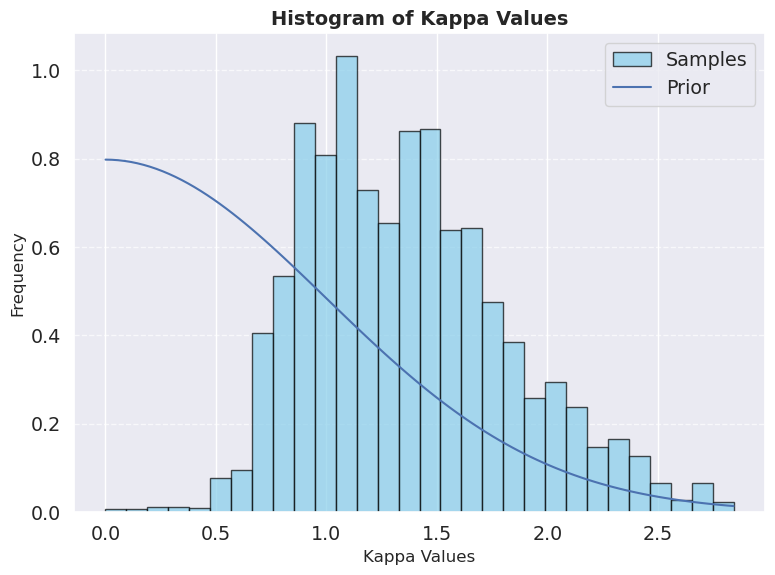

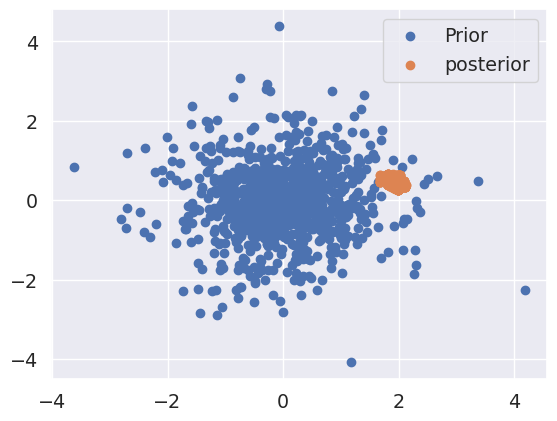

In [127]:

import numpy as np
kappas = thetas[:,2]
ks = jnp.linspace(0.0005,jnp.max(kappas), 100)
# Plot the histogram of kappas
plt.figure(figsize=(8, 6))  # Set figure size
plt.hist(kappas, bins=30, color='skyblue', edgecolor='black', alpha=0.7, density=True, label = 'Samples')  # Adjust binsand style
plt.plot(ks, half_npdf(ks,0,1), label = 'Prior')
plt.xlabel('Kappa Values', fontsize=12)  # Add x-axis label
plt.ylabel('Frequency', fontsize=12)  # Add y-axis label
plt.title('Histogram of Kappa Values', fontsize=14, fontweight='bold')
plt.legend()  # Add title
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

from scipy.stats import norm
init_kappas = jnp.abs(norm.rvs(0, 1, size = 1000))

w0s = jnp.zeros_like(init_kappas)
w1s = jnp.zeros_like(init_kappas)

for i,kappa in enumerate(init_kappas):
    init_weights = multivariate_normal.rvs(jnp.array([0,0]), kappa * jnp.identity(2))
    w0s = w0s.at[i].set(init_weights[0])
    w1s = w1s.at[i].set(init_weights[1])

kappas_end = kappas[-1000:]

plt.scatter(w0s, w1s, label =  'Prior')
plt.scatter(thetas[-1000:,0], thetas[-1000:,1], label = 'posterior')

# for i,kappa in enumerate(kappas_end):
#     init_weights = multivariate_normal.rvs(jnp.array([0,0]), kappa * jnp.identity(2))
#     w0s = w0s.at[i].set(init_weights[0])
#     w1s = w1s.at[i].set(init_weights[1])

# plt.scatter(w0s, w1s, label = 'Posterior')
plt.legend()

In [119]:
print(kappas_end[-1000:].mean())
print(init_kappas[-1000:].mean())

1.2400838
0.76637715


### Making predictions

Now that we have posterior samples for the weights, i.e. $\mathbf{w}^{(i)} \sim p(\mathbf{w} | \mathbf{y})$, we can use them to compute and plot the posterior predictive distribution $p(y^*|\mathbf{y}, \mathbf{x}^*)$ for age between 25 and 70 for our Bayesian Poisson regression model using MC sampling:

$$\begin{align*}
f_*^{(i)} &= (\mathbf{w}^{(i)})^T\mathbf{x}^*\\
\mu_*^{(i)} &= \exp(f_*^{(i)})\\
y_*^{(i)} &\sim \text{Poisson}(\mu_*^{(i)})
\end{align*}$$


for each posterior sample $i = 1, 2, \dots, S$. 

The variable `X_star` is a (P x 2)-shaped array, which contains the input values for the predictions, where $P = 100$ is the number of points in the interval from 25 to 70.

**Task 4.4**: Complete the implementation of the variable `f_star_samples`, `mu_star_samples`, and `y_star_samples`, which should all be (P x num_mcmc_samples)-shapes arrays containing posterior/posterior predictive samples of $f^*$, $\mu^*$ and $y^*$, respectively.

(1000, 2)
(100, 2)
(100, 1000)
(100, 1000)


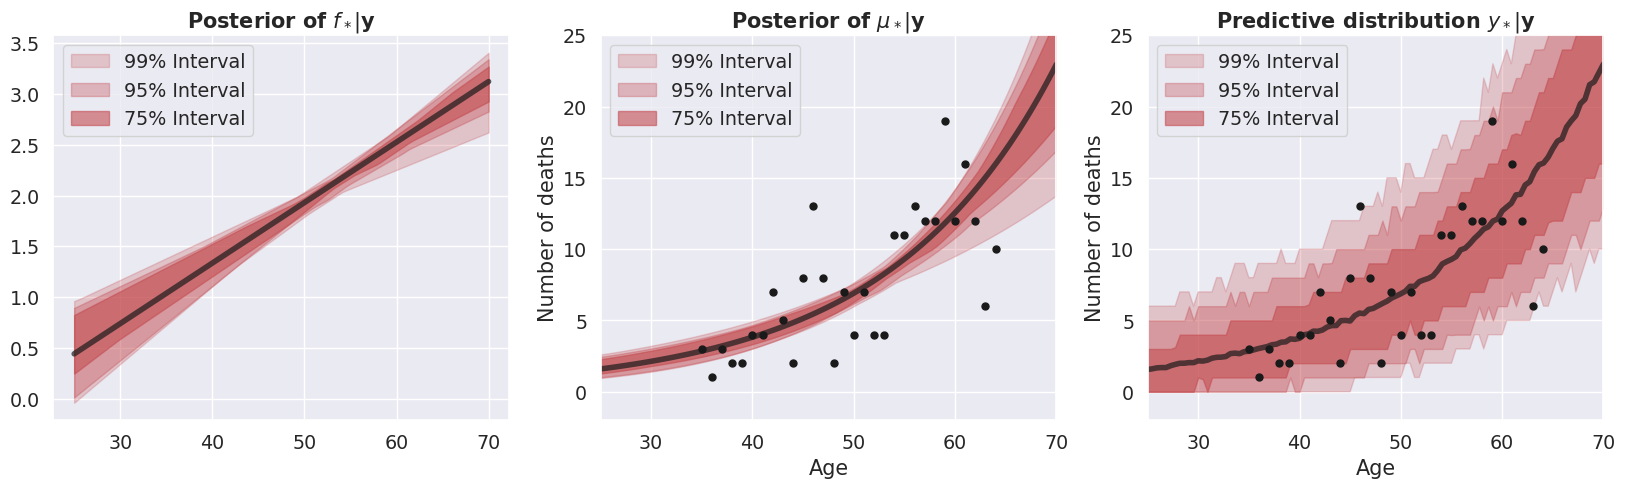

In [93]:
# making predictions by mapping the posterior samples of theta = (w, kappa) through the model

num_mcmc_samples = 1000
Ws = thetas[- num_mcmc_samples:,0:2]
print(Ws.shape)
print(X_star.shape)
f_star_samples = X_star @ Ws.T  # the result must be a (100 x num_mcmc_samples)-array 
print(f_star_samples.shape)
mu_star_samples = jnp.exp(f_star_samples) # the result must be a (100 x num_mcmc_samples)-array 
y_star_samples = poisson.rvs(mu_star_samples) # the result must be a (100 x num_mcmc_samples)-array 
print(y_star_samples.shape)

# plot
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plot_predictions(axes[0], age_star, f_star_samples.T, num_samples=0, legend=True, title='Posterior of $f_*|\mathbf{y}$')
plot_predictions(axes[1], age_star, mu_star_samples.T, num_samples=0, legend=True, title='Posterior of $\mu_*|\mathbf{y}$')
plot_predictions(axes[2], age_star, y_star_samples.T, num_samples=0, legend=True, title='Predictive distribution $y_*|\mathbf{y}$')
plot_data(axes[1])
plot_data(axes[2])

**Task 4.5**: Compute and visualize the posterior distributions for $f_*, \mu_*, y_*$ for $\text{age} = 75$ and report the mean and standard deviation of $p(y_*|\mathbf{y})$ for $\text{age} = 75$





(1, 1000)
(1000,)


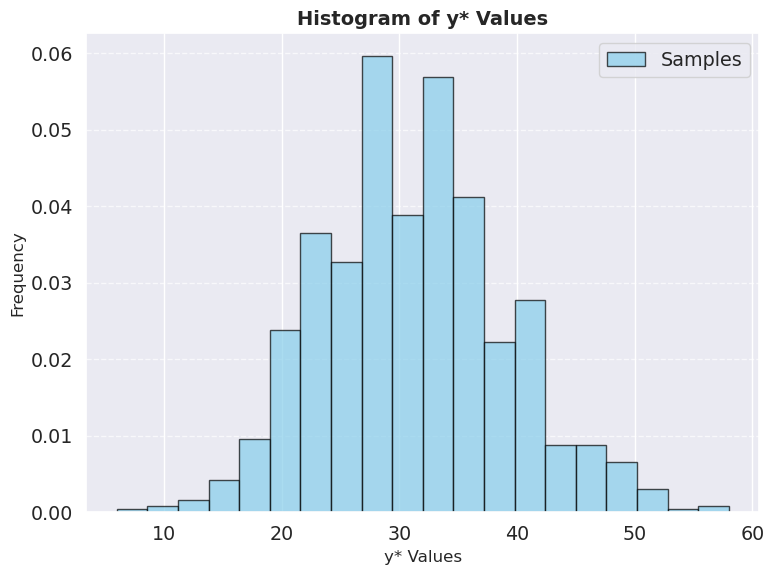

Mean 31.068
Variance: 7.785844591307998


In [129]:
xstar = jnp.array([(75 - m_age) / s_age])
xstar = design_matrix(xstar)

f_star_samples = xstar @ Ws.T  # the result must be a (100 x num_mcmc_samples)-array 
print(f_star_samples.shape)
mu_star_samples = jnp.exp(f_star_samples) # the result must be a (100 x num_mcmc_samples)-array 
y_star_samples = poisson.rvs(mu_star_samples) # the result must be a (100 x num_mcmc_samples)-array 
print(y_star_samples.shape)

plt.figure(figsize=(8, 6))  # Set figure size
plt.hist(y_star_samples.squeeze(), bins=20, color='skyblue', edgecolor='black', alpha=0.7, density=True, label = 'Samples')  # Adjust binsand style
plt.xlabel('y* Values', fontsize=12)  # Add x-axis label
plt.ylabel('Frequency', fontsize=12)  # Add y-axis label
plt.title('Histogram of y* Values', fontsize=14, fontweight='bold')
plt.legend()  # Add title
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

print(f'Mean {y_star_samples.mean()}')
print(f'Variance: {y_star_samples.std()}')


## Part 5:  Importance sampling



In the final part, we will briefly look at **importance sampling**. Recall, importance sampling is tool for estimating expectations of a function $f$ wrt. a target distribution $p$ using samples from a **proposal distribution** $q$:

$$\begin{align*}
\mathbb{E}_p \left[f(z)\right] = \mathbb{E}_q \left[f(z) \frac{p(z)}{q(z)}\right] \approx \frac{1}{S}\sum_{i=1}^S w^{(i)} f(z^{(i)}) \equiv \hat{f}, \quad z^{(i)} \sim q(z) \quad \text{for} \quad i = 1, \dots, S,
\end{align*}$$

where the **importance weights** $w^{(i)}$ are given by $w^{(i)} = \frac{p(z^{(i)})}{q(z^{(i)})}$. 

Consider again the following Skew-normal distribution:


$$\begin{align*}
p(z) &= 2\phi(z)\Phi(5z),
\end{align*}$$

which is plotted below:

In [ ]:
p = lambda z: 2*norm.pdf(z)*norm.cdf(5*z)
q1 = lambda z: npdf(z, 1,1)
q2 = lambda z: npdf(z, 4,1)

zs = np.linspace(-3, 7, 1000)
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(zs, p(zs), label='$p(z)$')
ax.plot(zs, q1(zs), label='$q_1(z)$', linestyle='--', alpha=0.5)
ax.plot(zs, q2(zs), label='$q_2(z)$', linestyle='--', alpha=0.5)
ax.set(xlabel='z', ylabel='density')
ax.legend();

The analytical mean of the distribution is given by 

$$\begin{align*}
\mathbb{E}\left[z\right] = \frac{5}{\sqrt{1+5^2}}\sqrt{\frac{2}\pi} \approx 0.7824
\end{align*}$$

**Task 5.1**: Use importance sampling with a Gaussian proposal, $q(z) = \mathcal{N}(z|1, 1)$, to estimate the mean of the target distribution $p$ for $S = 1000$. How many samples $S$ do you need to get a decent estimate?

*Hints*:
- *Implement a function for computing the importance sampling estimate wrt. the target distribution given the mean and variance of the proposal distribution as well as number of samples to use.*



The importance sampling estimator is an **unbiased** estimator, but for importance sampling to work well in practice, the proposal distribution $q$ needs to be relatively "well-aligned" with the target distribution $p$. In the next task, you are going to design a small numerical experiment to investigate this.

**Task 5.2**: Consider two different proposal distributions $q_1(z) = \mathcal{N}(z|1,1)$ and $q_2(z) = \mathcal{N}(z|4,1)$. Compute and plot the importance sampling estimate for the mean of $p(z)$ for both proposal distributions as a function the sample size $S$. Since the importance sampling is an inherently stochastic procedure, you should consider repeating the experiment several times and plot the mean and variance of the estimator across the repetitions as a function of $S$.

*Hints*:
- *There are many valid ways to implement this. The simplest is likely to be via nested for-loops, e.g. an "inner" for loop over the sample size and an "outer" for-loop over the repetitions*
- *Consider $S$ in the range from $S = 1$ to $S = 10^4$.*
- *Remember to use a different seed/key for each repetition.*

